In [3]:
import wrf as w
import numpy as np
import xarray as xr
import pandas as pd 
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cmaps
import os 
import salem 
from zIO import load_modis, load_t
from zProcess import load_NamCo_shp, mask_lake
from zMap import set_grid, add_NamCo
import warnings
warnings.filterwarnings("ignore")

if __name__ == '__main__':
    data_dir = '/home/zzhzhao/Model/wrfout'
    testname_list = [
        'modis',
        'test-25-3',
        'test-25-NL',
        'test-25-NM',
        ]
    N_test = len(testname_list)

    date_start = '2013-08-23'
    date_end = '2013-09-01'

#     day_or_night = 'Day'
    day_or_night = 'Night'
    tsk_list = dict()
    tsk_NamCo_daily_list = dict()
    for testname in testname_list:
        if testname == 'modis':
            file_path = f"/home/Public_Data/MODIS/MOD11A1/MOD11A1_NamCo_{date_start[:4]}.nc"
            tsk_list[testname] = load_modis(file_path, date_start, date_end, day_or_night)
            tsk_NamCo_daily_list[testname] = tsk_list[testname]
        else:
            data_path = os.path.join(data_dir, testname)
            domain = 1 
            tsk, lats, lons, time = load_t(data_path, domain, 'TSK')
            tsk = xr.where(tsk>0, tsk, np.nan)
            tsk_list[testname] = tsk

            mask = mask_lake(data_path, load_NamCo_shp(), testname, domain)
            tsk_NamCo = tsk.where(mask) # 切出NamCo范围
            tsk_NamCo_mean = tsk_NamCo.mean(dim=['west_east','south_north'])
            # tsk_NamCo_mean = tsk_NamCo.isel(west_east=74, south_north=39)
            

            ### 取3 UTC和6 UTC的平均
            if day_or_night == 'Day':
                hour_list = [3, 6]
            else:
                hour_list = [15, 18]
            tsk_NamCo_daily = tsk_NamCo_mean.sel(Time=tsk_NamCo_mean.Time.dt.hour.isin(hour_list)).resample(Time='D').mean()
            tsk_NamCo_daily_list[testname] = tsk_NamCo_daily



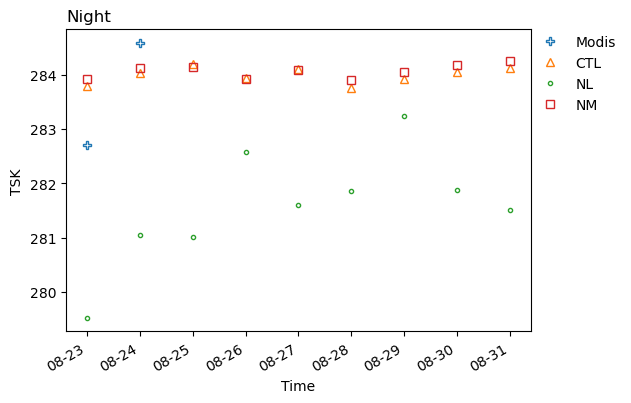

In [4]:
    labels = [
        'Modis',
        'CTL',
        'NL', 
        'NM', 
        ]
    markers = list('P^.sxD+*p12')
    fig, ax = plt.subplots(dpi=100)
    for i, testname in enumerate(testname_list):
        var = tsk_NamCo_daily_list[testname]

        var.plot.line(lw=0, marker=markers[i], mfc='none', label=labels[i], ax=ax)
        ax.legend(loc=2, bbox_to_anchor=(1.0,1.0), borderaxespad=0, frameon=False)
        ax.set_title(day_or_night, loc='left')
        import matplotlib.dates as mdate  
        ax.xaxis.set_major_formatter(mdate.DateFormatter('%m-%d'))

    fig.savefig('fig/lwst_alltest.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)

    